# Train the LSTM neural classifier

Training of the **LSTM neural network classifier** for producing results with various **degrees of dataset imbalance**. The trained model is further saved to reproduce the results for testing.

## Import useful packages

In [ ]:
# Generic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

In [ ]:
# Sci-kit learn for machine learning tasks
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, make_scorer

In [ ]:
# TensorFlow and Keras for neural networks
from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential
from keras import layers
from keras.layers.wrappers import Bidirectional
from keras.regularizers import l2
from keras import metrics
from tensorflow.keras.optimizers import Adam

In [ ]:
# NLTK for natural language processing
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
# Custom helper-functions script (supplied to Colab manually)
import utils as uu

## Define the neural architecture

In [ ]:
# Set parameters tuned beforehand via Bayesian optimization
params = {'batch_size':     19,
          'dropout_rate':   0.44620052554868306,
          'embedding_dim':  185,
          'epochs':         48,
          'l2_val':         2.075894563815948e-06,
          'learning_rate':  0.00011309278658953993,
          'max_words':      5000,
          'max_len':        55,
          'n_units':        14,
          }

In [ ]:
# Define the neural model
def create_model(params, word_index):
    
    # Define optimizer
    opt = Adam(learning_rate=params['learning_rate'], 
               beta_1 = 0.9,
               beta_2 = 0.99,
               epsilon = 1e-07,
               amsgrad = False)

    # Define sequential neural arhitecture
    model = Sequential()
    model.add(layers.Embedding(params['max_words'], params['embedding_dim'], input_length=params['max_len']))
    model.add(Bidirectional(layers.LSTM(params['n_units'], dropout=params['dropout_rate'], recurrent_dropout=0, unroll=False, kernel_initializer=params['init_mode'])))
    model.add(layers.Dense(1, kernel_initializer=params['init_mode'], activation='sigmoid', kernel_regularizer=l2(params['l2_val']), bias_regularizer=l2(params['l2_val'])))

    # Build model
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[metrics.AUC(name='auc_pr', curve="PR")])
    #model.compile(loss=[uu.focal_loss], optimizer=opt, metrics=[metrics.AUC(name='auc_pr', curve="PR")])
    model.summary()

    return model

## Load the datasets

In [ ]:
# Set file names
train_set_file  = "train_set_imb_0.csv"
test_set_file   = "test_set_imb_0.csv"
model_file      = "model_lstm_imb_0.h5"

In [ ]:
# Read train and test sets as dataframes
train_set = pd.read_csv(train_set_file)
test_set = pd.read_csv(test_set_file)

In [ ]:
# Preprocess texts
train_set['text'] = train_set['text'].apply(str)
train_set['text'] = train_set['text'].apply(uu.preprocess_text)
test_set['text'] = test_set['text'].apply(str)
test_set['text'] = test_set['text'].apply(uu.preprocess_text)

In [ ]:
# Decouple texts and labels (deep copy to not modfy the original datasets accidentally)
texts_train = copy.deepcopy(train_set['text'])
labels_train = copy.deepcopy(train_set['is_about_cc'])
texts_test = copy.deepcopy(test_set['text'])
labels_test = copy.deepcopy(test_set['is_about_cc'])

In [ ]:
# Show the test obtained set fraction (should be 15%)
share_test = len(labels_test)/(len(labels_train)+len(labels_test))
print(share_test)

0.149886976178056


## Create features and fit the model

In [ ]:
# Tokenize texts and get features
tokenizer = Tokenizer(num_words=params['max_words'])
tokenizer.fit_on_texts(texts_train)
sequences_train = tokenizer.texts_to_sequences(texts_train)
features_train = sequence.pad_sequences(sequences_train, maxlen=params['max_len'], padding='post', truncating='post')
sequences_test = tokenizer.texts_to_sequences(texts_test)
features_test = sequence.pad_sequences(sequences_test, maxlen=params['max_len'], padding='post', truncating='post')
word_index = tokenizer.word_index

In [ ]:
# Create the model
model = create_model(params, word_index=tokenizer.word_index)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 55, 185)           925000    
                                                                 
 bidirectional_3 (Bidirectio  (None, 28)               22400     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 1)                 29        
                                                                 
Total params: 947,429
Trainable params: 947,429
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compute class weights for compensation the imbalance in classes
class_weights = class_weight.compute_class_weight(class_weight = "balanced", classes = np.unique(labels_train), y = labels_train)
class_weights = dict(zip(np.unique(labels_train), class_weights))
print(class_weights)

{0: 0.540579389650597, 1: 6.660762942779291}


In [ ]:
# Fit the model
history = model.fit(features_train, labels_train, 
                    epochs=params['epochs'], 
                    verbose=True, 
                    batch_size=params['batch_size'], 
                    class_weight=class_weights) 


Epoch 1/48
258/258 [==============================] - 5s 9ms/step - loss: 0.6895 - auc_pr: 0.1127
Epoch 2/48
258/258 [==============================] - 2s 9ms/step - loss: 0.6698 - auc_pr: 0.4074
Epoch 3/48
258/258 [==============================] - 2s 9ms/step - loss: 0.6214 - auc_pr: 0.6521
Epoch 4/48
258/258 [==============================] - 2s 9ms/step - loss: 0.5420 - auc_pr: 0.7655
Epoch 5/48
258/258 [==============================] - 2s 9ms/step - loss: 0.4495 - auc_pr: 0.8162
Epoch 6/48
258/258 [==============================] - 2s 9ms/step - loss: 0.3677 - auc_pr: 0.8540
Epoch 7/48
258/258 [==============================] - 2s 9ms/step - loss: 0.3009 - auc_pr: 0.8801
Epoch 8/48
258/258 [==============================] - 2s 9ms/step - loss: 0.2494 - auc_pr: 0.9018
Epoch 9/48
258/258 [==============================] - 2s 9ms/step - loss: 0.2118 - auc_pr: 0.9138
Epoch 10/48
258/258 [==============================] - 2s 9ms/step - loss: 0.1838 - auc_pr: 0.9254
Epoch 11/48
258/258

In [ ]:
# Save the model (needs to be downloaded manyally from Colab)
model.save(model_file)

## Test the model for performance

In [ ]:
# Compute PR AUC score (area under the precision-recall curve)
prediction_scores = model.predict(features_test).ravel()
precs, recs = uu.compute_pr(labels_test, prediction_scores)
pr_auc = auc(recs, precs)
pr_auc

0.5116429979482426

In [ ]:
# Compute F1 score
predicted_labels = (model.predict(features_test) > 0.5).astype(int)
acc, prec, rec, f1 = uu.compute_perf_metrics(labels_test, predicted_labels)
print("f1 = ", f1)

f1 =  0.5565217391304348


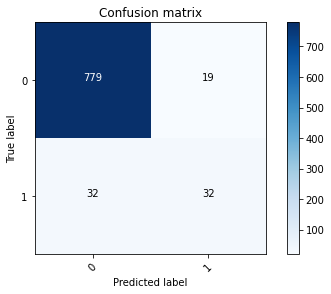

In [ ]:
# Compute confusion matrix
confusion_mat = confusion_matrix(labels_test, predicted_labels)
uu.plot_confusion_matrix(confusion_mat, classes=[0, 1], title='Confusion matrix')

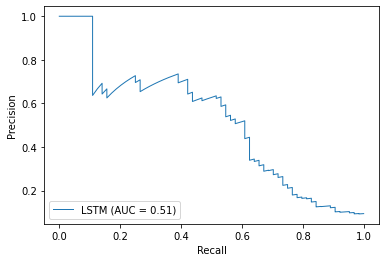

In [ ]:
# Plot precision-recall curve
plt.plot(recs, precs, linewidth=1, label=' '.join(['LSTM', '(AUC = %0.2f)' % pr_auc]))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")